## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F

from datetime import datetime
from tqdm.notebook import tqdm

## Device

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Dataset

In [3]:
transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder("plant_leave_diseases_dataset_with_augmentation", transform=transform)
dataset

Dataset ImageFolder
    Number of datapoints: 61486
    Root location: plant_leave_diseases_dataset_with_augmentation
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
           )

In [4]:
indices = list(range(len(dataset)))
split = int(np.floor(0.85 * len(dataset)))
validation = int(np.floor(0.70 * split))
np.random.shuffle(indices)

## Split Dataset

In [5]:
train_ids, validation_ids, test_ids = (
    indices[:validation],
    indices[validation:split],
    indices[split:]
)

train_sampler = SubsetRandomSampler(train_ids)
validation_sampler = SubsetRandomSampler(validation_ids)
test_sampler = SubsetRandomSampler(test_ids)

print(f"length of train size: {len(train_sampler)}")
print(f"length of validation size: {len(validation_sampler)}")
print(f"length of test size: {len(test_sampler)}")

length of train size: 36584
length of validation size: 15679
length of test size: 9223


In [6]:
targets_size = len(dataset.class_to_idx)
targets_size

39

## Dataloader

In [7]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=train_sampler
)
test_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=test_sampler
)
validation_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=validation_sampler
)

## Model

In [8]:
class CNN_Model(nn.Module):

    def __init__(self, K):
        super(CNN_Model, self).__init__()
        self.conv1 = self._block(c1_in=3, c2_in=32, c_out=32, b_norm=32)
        self.conv2 = self._block(c1_in=32, c2_in=64, c_out=64, b_norm=64)
        self.conv3 = self._block(c1_in=64, c2_in=128, c_out=128, b_norm=128)
        self.conv4 = self._block(c1_in=128, c2_in=256, c_out=256, b_norm=256)

        self.dense_layers = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(50176, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, K),
        )

    def _block(self, c1_in, c2_in, c_out, b_norm, k=3, p=1, pk=2):
        return torch.nn.Sequential(
            nn.Conv2d(in_channels=c1_in, out_channels=c_out, kernel_size=k, padding=p),
            nn.ReLU(),
            nn.BatchNorm2d(b_norm),
            nn.Conv2d(in_channels=c2_in, out_channels=c_out, kernel_size=k, padding=p),
            nn.ReLU(),
            nn.BatchNorm2d(b_norm),
            nn.MaxPool2d(pk),
        )

    def forward(self, X):
        out = self.conv1(X)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)

        # Flatten
        out = out.view(-1, 50176)

        # Fully connected
        out = self.dense_layers(out)

        return out

In [9]:
model = CNN_Model(targets_size).to(device)
model

CNN_Model(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, 

## Load Model

In [10]:
model.load_state_dict(torch.load("weights/plant_disease_model_latest.pt"))

<All keys matched successfully>

## Fit Function and Training

In [11]:
def batch_gd(model, train_loader, validation_loader, epochs):
    criterion = nn.CrossEntropyLoss()  # this include softmax + cross entropy loss
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    train_losses = np.zeros(epochs)
    validation_losses = np.zeros(epochs)

    for e in range(epochs):
        t0 = datetime.now()
        train_loss = []
        model.train()
        bar = tqdm(train_loader)

        for inputs, targets in bar:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, targets)
            train_loss.append(loss.item())  # torch to numpy world
            loss.backward()
            optimizer.step()
            bar.set_description(f"loss {np.mean(train_loss):.5f}")

        train_loss = np.mean(train_loss)
        validation_loss = []
        model.eval()
        bar = tqdm(validation_loader)

        with torch.no_grad():
            for inputs, targets in bar:
                inputs, targets = inputs.to(device), targets.to(device)
                output = model(inputs)
                loss = criterion(output, targets)
                validation_loss.append(loss.item())  # torch to numpy world
                bar.set_description(f"val_loss {np.mean(validation_loss):.5f}")

            validation_loss = np.mean(validation_loss)
            train_losses[e] = train_loss
            validation_losses[e] = validation_loss

        dt = datetime.now() - t0
        print(
            f"Epoch:{e+1}/{epochs} Train_loss:{train_loss:.5f} Validation_loss:{validation_loss:.5f} Duration:{dt}"
        )
    return train_losses, validation_losses

In [12]:
train_losses, validation_losses = batch_gd(model, train_loader, validation_loader, 5)

  0%|          | 0/572 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

Epoch:1/5 Train_loss:0.46674 Validation_loss:0.76106 Duration:0:11:39.889243


  0%|          | 0/572 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

Epoch:2/5 Train_loss:0.32386 Validation_loss:0.20074 Duration:0:15:00.771143


  0%|          | 0/572 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

Epoch:3/5 Train_loss:0.28513 Validation_loss:0.72813 Duration:0:16:12.233147


  0%|          | 0/572 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

Epoch:4/5 Train_loss:0.25962 Validation_loss:0.23287 Duration:0:17:00.211170


  0%|          | 0/572 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

Epoch:5/5 Train_loss:0.21163 Validation_loss:0.30513 Duration:0:27:43.606822


## Save Model

In [13]:
torch.save(model.state_dict(), 'weights/plant_disease_model_3.pt')

## Plotting Loss

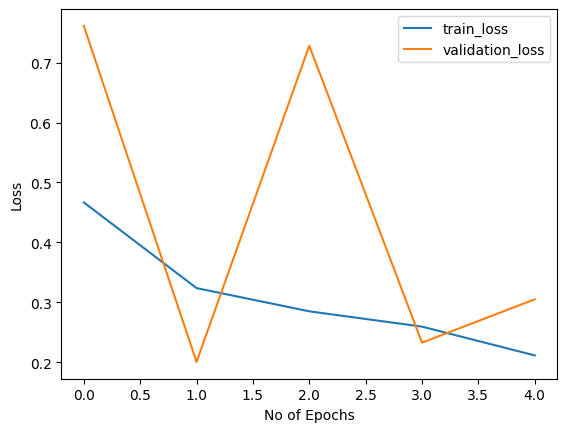

In [14]:
plt.plot(train_losses , label = 'train_loss')
plt.plot(validation_losses , label = 'validation_loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Accuracy

In [15]:
def accuracy(loader):
    n_correct = 0
    n_total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)

        _, predictions = torch.max(outputs, 1)

        n_correct += (predictions == targets).sum().item()
        n_total += targets.shape[0]

    acc = n_correct / n_total
    return acc

In [ ]:
model.eval()

train_acc = accuracy(train_loader)
test_acc = accuracy(test_loader)
validation_acc = accuracy(validation_loader)

print(f"Train Accuracy: {train_acc}\n Test Accuracy: {test_acc}\n Validation Accuracy: {validation_acc}")